### A. Goldman, N. Puchkin, V. Shcherbakova, and U. Vinogradova

### Numerical experiments on artificial data sets, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [9]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt

# Import the algorithms for comparison
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.contrastive_change_point import compute_test_stat_nn
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum

%matplotlib inline

np.random.seed(1)

In [10]:
# Auxiliary function to compute delays
def compute_delays(true_cp, detected_cp):
    
    false_alarms = 0
    not_detected = 0
    delays = []
    
    cp_all = np.append(true_cp, detected_cp)
    pattern = np.append(np.zeros(len(true_cp)), np.ones(len(detected_cp)))
    
    ind_sorted = np.argsort(cp_all)
    cp_sorted = cp_all[ind_sorted]
    pattern_sorted = pattern[ind_sorted]
    
    #print(true_cp, detected_cp)
    #print(cp_sorted)
    #print(pattern_sorted)
    
    if pattern_sorted[0] == 1:
        false_alarms += 1
        #print('False alarm')
        
    for i in range(1, len(pattern_sorted)):

        # Correctly detected change point
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            #print('Correctly detected')
            
        # False alarm
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 1) and (i < len(pattern_sorted) - 1):
            false_alarms += 1
            #print('False alarm')
            
        # Non-detected change point
        if (pattern_sorted[i] == 0) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            not_detected += 1
            #print('Not detected')
    
    #print(delays)
    delays = np.array(delays)
    delays_mean = np.mean(delays)
    delays_std = np.std(delays)
    
    return false_alarms, delays_mean, delays_std, not_detected

### WISDM data set

In [11]:
# Read the data
df = pd.read_csv('data/WISDM/sample_0.csv')

# Feature vectors
X = np.array(df[['X1', 'X2', 'X3']])
print(X.shape)

# Labels
labels = np.array(df['Label'])
change_points = np.where(labels)[0]

(64868, 3)


In [12]:
# Data preprocessing
# Reduce the data, averaging over 20 values

bandwidth = 20
N = X.shape[0] // bandwidth

data = np.empty((0, 3))
new_labels = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(X[bandwidth * t : bandwidth * (t + 1)], axis=0).reshape(1, -1), axis=0)
    new_labels = np.append(new_labels, np.sum(labels[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = np.where(new_labels)[0]
print(change_points)

[ 180  360  540  720  900 1080 1260 1440 1620 1801 1981 2161 2341 2521
 2702 2882 3063]


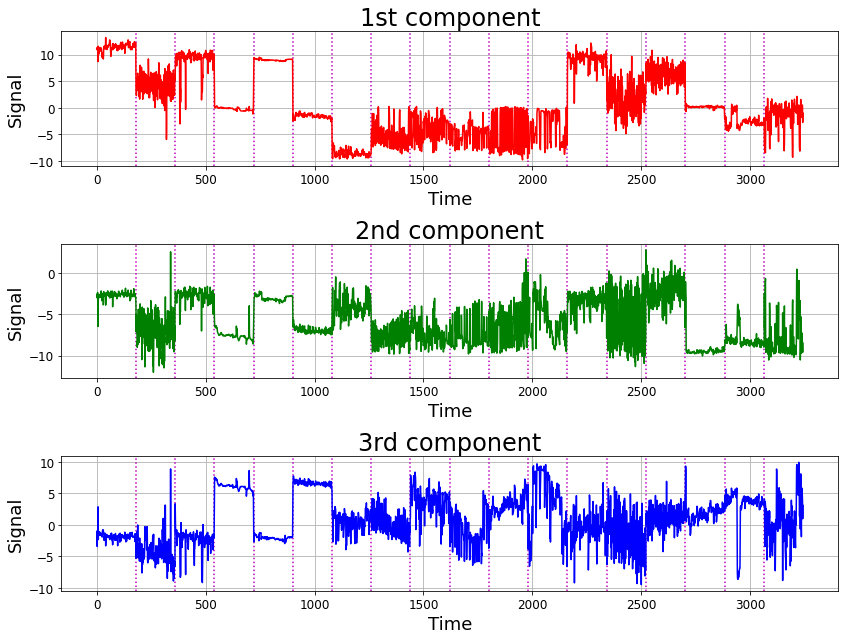

In [13]:
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='1st component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 1], c='g')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='2nd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 2], c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='3rd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.tight_layout()

In [14]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:180], data[181:360], data[361:540], data[541:720]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = 0
val_end = 1670
data_val = data[val_start:val_end]

# Test part: check the performance of the procedures
test_start = 1670
test_end = 3060
data_test = data[test_start:test_end]

### Contrastive change point detection

#### With a linear class

In [15]:
p = 1

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    

S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='multivariate', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 0.6 * np.max(S_stationary)
print('Threshold:', z)


#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_lin = np.empty(0)

# Initialization of the list of detected change points
change_points_lin = []

# Initialization of the delays array and
# the false alarms counter
delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0


# Initialization
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_test[st_lin + 1:], p,\
                                                     design='multivariate', threshold=z, delta_max=50)

    S_lin = np.append(S_lin, new_S_lin)

    if new_st_lin >= 0:
        st_lin += new_st_lin
        change_points_lin += [int(st_lin)]
    else:
        change_points_lin += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_lin)
    
false_alarms_lin, mean_delay_lin, std_delay_lin, not_detected_lin\
= compute_delays(change_points_test, change_points_lin)

print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.round(mean_delay_lin, 4), '±', np.round(std_delay_lin, 4),\
      '; non-detected:', not_detected_lin)

Threshold: 28.072564631389547
Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [148, 374, 505, 702, 878, 1055, 1235, 1389]
Linear class. Number of false alarms: 0 ; average delay: 28.2857 ± 15.1253 ; non-detected: 0


#### With a class of neural networks

In [27]:
#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_nn(ds, n_epochs=20, delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 0.45 * np.max(S_stationary)
print('Threshold:', z)


#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_nn = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []

# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_test[st_nn + 1:], threshold=z, n_epochs=20, delta_max=50)

    S_nn = np.append(S_nn, new_S_nn)

    if new_st_nn >= 0:
        st_nn += new_st_nn
        change_points_nn += [int(st_nn)]
    else:
        change_points_nn += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_nn)
    
false_alarms_nn, mean_delay_nn, std_delay_nn, not_detected_nn\
= compute_delays(change_points_test, change_points_nn)

print('Neural networks. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.round(mean_delay_nn, 4), '±', np.round(std_delay_nn, 4),\
      '; non-detected:', not_detected_nn)

Threshold: 5.595171984632453
Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [147, 245, 405, 482, 526, 977, 1164, 1321, 1389]
Neural networks. Number of false alarms: 2 ; average delay: 98.8571 ± 52.7648 ; non-detected: 1


### Fast contrastive change point detection algorithm

In [17]:
p = 1

# The list of hyperparameters
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='multivariate')
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print('beta =', b, ', threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization of the list of detected change points
    change_points_ftal = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = np.empty(0)
    current_change_point_ind = 0
    false_alarms_ftal = 0

    # Initialization
    st_ftal = 0
    new_st_ftal = 0
    
    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                       design='multivariate', threshold=z)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            change_points_ftal += [int(st_ftal)]
        else:
            change_points_ftal += [int(data_val.shape[0] - 1)]

    #print('Detected change points:', change_points_ftal)
    
    false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
    = compute_delays(change_points_val, change_points_ftal)

    print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
          '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
          '; non-detected:', not_detected_ftal)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
beta = 0.005 , threshold = 37.13810437946081
FTAL, beta = 0.005 . Number of false alarms: 0 ; average delay: 49.8889 ± 16.0516 ; non-detected: 0
beta = 0.01 , threshold = 36.407864852732416
FTAL, beta = 0.01 . Number of false alarms: 0 ; average delay: 50.2222 ± 16.4166 ; non-detected: 0
beta = 0.02 , threshold = 34.95604424615047
FTAL, beta = 0.02 . Number of false alarms: 0 ; average delay: 53.3333 ± 21.0924 ; non-detected: 0
beta = 0.05 , threshold = 32.524347061580556
FTAL, beta = 0.05 . Number of false alarms: 0 ; average delay: 51.0 ± 20.6505 ; non-detected: 0
beta = 0.1 , threshold = 26.425672736975528
FTAL, beta = 0.1 . Number of false alarms: 0 ; average delay: 56.6667 ± 35.7243 ; non-detected: 0
beta = 0.2 , threshold = 22.845968421999736
FTAL, beta = 0.2 . Number of false alarms: 0 ; average delay: 56.8889 ± 46.8839 ; non-detected: 1
beta = 0.5 , threshold = 16.103811639978048
FTAL, beta = 0.5 . Number 

In [18]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 3.82
b = 2.5
    
# Change points on the validation set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
    
# Initialization of the test statistic
S_ftal = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_test[st_ftal + 1:], p, beta=b,\
                                                       design='multivariate', threshold=z)

    S_ftal = np.append(S_ftal, new_S_ftal)

    if new_st_ftal >= 0:
        st_ftal += new_st_ftal
        change_points_ftal += [int(st_ftal)]
    else:
        change_points_ftal += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_ftal)
    
false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
= compute_delays(change_points_test, change_points_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
      '; non-detected:', not_detected_ftal)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [145, 380, 496, 749, 868, 1054, 1221, 1280, 1389]
FTAL, beta = 2.5 . Number of false alarms: 1 ; average delay: 30.5714 ± 27.7172 ; non-detected: 0


### KLIEP

In [19]:
# The list of hyperparameters
sigma_list = [10, 20, 25, 40, 50]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print(z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization of the list of detected change points
    change_points_kliep = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_kliep = np.empty(0)
    current_change_point_ind = 0
    false_alarms_kliep = 0

    # Initialization
    st_kliep = 0
    new_st_kliep = 0
    
    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                            window_size=50, sigma=sigma, threshold=z)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]
        else:
            change_points_kliep += [int(data_val.shape[0] - 1)]

    #print('Detected change points:', change_points_kliep)
    
    false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
    = compute_delays(change_points_val, change_points_kliep)

    print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
          '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
          '; non-detected:', not_detected_kliep)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
3.774082378137586
KLIEP, bandwidth = 10 . Number of false alarms: 2 ; average delay: 17.3333 ± 20.199 ; non-detected: 0
1.1515116438240642
KLIEP, bandwidth = 20 . Number of false alarms: 0 ; average delay: 7.5556 ± 3.9472 ; non-detected: 0
0.7507193657817826
KLIEP, bandwidth = 25 . Number of false alarms: 1 ; average delay: 12.4444 ± 13.2423 ; non-detected: 0
0.3000150269997258
KLIEP, bandwidth = 40 . Number of false alarms: 1 ; average delay: 13.3333 ± 13.0639 ; non-detected: 0
0.1914766380951327
KLIEP, bandwidth = 50 . Number of false alarms: 1 ; average delay: 13.1111 ± 13.1525 ; non-detected: 0


In [20]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 1.1525948824041012
sigma = 20
    
# Change points on the validation set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_kliep = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_kliep)
    
false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_test, change_points_kliep)

print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
      '; non-detected:', not_detected_kliep)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [125, 229, 330, 431, 532, 681, 782, 883, 1033, 1227, 1329, 1389]
KLIEP, bandwidth = 20 . Number of false alarms: 4 ; average delay: 30.8571 ± 30.0734 ; non-detected: 0


### M-statistic

In [21]:
# The list of hyperparameters
sigma_list = [10, 20, 25, 40, 50]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print(z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization of the list of detected change points
    change_points_mmd = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_mmd = np.empty(0)
    current_change_point_ind = 0
    false_alarms_mmd = 0

    # Initialization
    st_mmd = 0
    new_st_mmd = 0
    
    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                            window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]
        else:
            change_points_mmd += [int(data_val.shape[0] - 1)]

    #print('Detected change points:', change_points_mmd)
    
    false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
    = compute_delays(change_points_val, change_points_mmd)

    print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
          '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
          '; non-detected:', not_detected_mmd)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
5.217594927197018
M-statistic, bandwidth = 10 . Number of false alarms: 2 ; average delay: 13.7778 ± 15.0095 ; non-detected: 0
1.7284497814725275
M-statistic, bandwidth = 20 . Number of false alarms: 1 ; average delay: 9.1111 ± 8.7996 ; non-detected: 0
1.1237385679629701
M-statistic, bandwidth = 25 . Number of false alarms: 1 ; average delay: 9.1111 ± 8.7996 ; non-detected: 0
0.44657933683968337
M-statistic, bandwidth = 40 . Number of false alarms: 1 ; average delay: 9.1111 ± 8.7996 ; non-detected: 0
0.2869555417166241
M-statistic, bandwidth = 50 . Number of false alarms: 1 ; average delay: 9.1111 ± 8.7996 ; non-detected: 0


In [22]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 1.7284497814725275
sigma = 20
    
# Change points on the validation set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_mmd = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_mmd)
    
false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_test, change_points_mmd)

print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
      '; non-detected:', not_detected_mmd)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [121, 226, 327, 428, 529, 681, 782, 883, 1039, 1229, 1330, 1389]
M-statistic, bandwidth = 20 . Number of false alarms: 4 ; average delay: 30.7143 ± 28.2424 ; non-detected: 0
